<a href="https://colab.research.google.com/github/safayetsawom/pytorch_deeplearning_practice/blob/main/Cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#convert mnist image files into a tensor of 4-dimensions(# of images , height, width,color channels)
train_data=datasets.MNIST(root='/cnn_data', train=True, download = True,transform=transforms.ToTensor())
test_data=datasets.MNIST(root='/cnn_data', train=False, download = True, transform=transforms.ToTensor())

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
#create a small batch size for images .. let's say 10
train_loader=DataLoader(train_data, batch_size=10, shuffle=True)
test_loader=DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
#define our cnn model
#describe convolutional layer and what it's doint(2 convolutional layers)
#this is just an example
conv1=nn.Conv2d(1,6,3,1)
conv2=nn.Conv2d(6,16,3,1)

In [ ]:
#grab 1 mnist record/image
for i, (X_Train,y_train) in enumerate(train_loader):
    break

In [ ]:
X_Train.shape

torch.Size([10, 1, 28, 28])

In [ ]:
#perform our first convolution
x=F.relu(conv1(X_Train)) #Rectified Linear Unit for our activation fumction

In [ ]:
x.shape

torch.Size([10, 6, 26, 26])

In [ ]:
#pass through the pooling layer
x=F.max_pool2d(x,2,2) #kernel of 2 and stride of 2

In [ ]:
x.shape #26/2=13

torch.Size([10, 6, 13, 13])

In [ ]:
#2nd convolutional layer
x=F.relu(conv2(x))

In [ ]:
x.shape

torch.Size([10, 16, 11, 11])

In [ ]:
#pooling layer
x=F.max_pool2d(x,2,2)

In [ ]:
x.shape #rouunded down

torch.Size([10, 16, 5, 5])

up we have the idea of how cnn model works by 2 conv layer and then 2 pooling layer


In [ ]:
#model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,6,3,1)
    self.conv2=nn.Conv2d(6,16,3,1)
    #fully connected layer
    self.fc1=nn.Linear(5*5*16,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.max_pool2d(x,2,2) #2*2 kernal and stride 2
    #Second pass
    x=F.relu(self.conv2(x))
    x=F.max_pool2d(x,2,2)
    #reshape for fully connected layer
    x=x.view(-1,5*5*16) #negative one so that we can vary the batch size
    x=F.relu(self.fc1(x)) #fully connected layers
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return F.log_softmax(x,dim=1)

In [ ]:
#create an instance of our model
torch.manual_seed(41)
model=ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
#loss function Optimizer
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
import time
start_time=time.time()

#Create variables to Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#for loop of Epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    #train
    for b,(X_train,y_train) in enumerate(train_loader):
        b+=1 #start our batches at 1
        y_pred = model(X_train) #get predicted values from the training set. Not flattened 2d
        loss = loss_function(y_pred,y_train) # how off are we? compare the prediction
        predicted = torch.max(y_pred.data,1)[1] #add up the number of correct predictionas. indexed off first point
        batch_corr = (predicted == y_train).sum() #how many we got correct from this batch. True=1, False=0, sum this up
        trn_corr += batch_corr #keep track as we go along in training.

        #update our parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print out some results
        if b%600 ==0:
          print(f"Epoch: {i} Batch {b} Loss: {loss.item()} Accuracy: {trn_corr.item()*100/(10*b)}")

    train_losses.append(loss)
    train_correct.append(trn_corr)
    #test
    with torch.no_grad():
      for b,(X_test,y_test) in enumerate(test_loader):
        y_val = model(X_test)
        predicted = torch.max(y_val.data,1)[1] #adding up correct predictions
        tst_corr +=(predicted==y_test).sum() #t=1 f=0 and sum away
    loss = loss_function(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

current_time=time.time()
total=current_time-start_time
print(f"Total Time: {total/60} minutes!")

Epoch: 0 Batch 600 Loss: 0.012505742721259594 Accuracy: 76.28333333333333
Epoch: 0 Batch 1200 Loss: 0.059554439038038254 Accuracy: 84.80833333333334
Epoch: 0 Batch 1800 Loss: 0.01286345161497593 Accuracy: 88.20555555555555
Epoch: 0 Batch 2400 Loss: 0.13558034598827362 Accuracy: 90.08333333333333
Epoch: 0 Batch 3000 Loss: 0.004820442292839289 Accuracy: 91.31333333333333
Epoch: 0 Batch 3600 Loss: 0.010546308942139149 Accuracy: 92.25277777777778
Epoch: 0 Batch 4200 Loss: 0.24395230412483215 Accuracy: 92.95476190476191
Epoch: 0 Batch 4800 Loss: 0.007479517254978418 Accuracy: 93.40416666666667
Epoch: 0 Batch 5400 Loss: 0.009367642924189568 Accuracy: 93.87222222222222
Epoch: 0 Batch 6000 Loss: 0.0018434313824400306 Accuracy: 94.23833333333333
Epoch: 1 Batch 600 Loss: 0.03221464157104492 Accuracy: 97.65
Epoch: 1 Batch 1200 Loss: 0.003333463566377759 Accuracy: 97.73333333333333
Epoch: 1 Batch 1800 Loss: 0.04126342386007309 Accuracy: 97.78888888888889
Epoch: 1 Batch 2400 Loss: 0.146855250000953

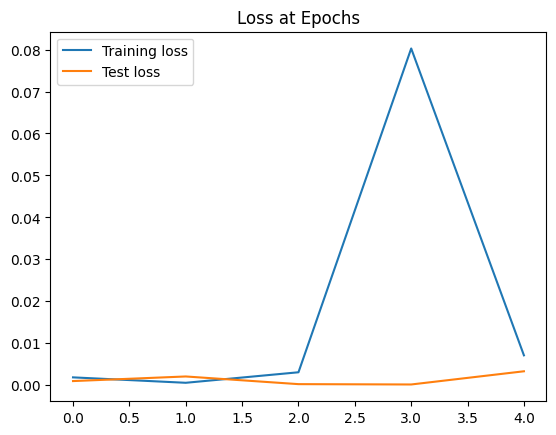

In [ ]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses,label="Training loss")
plt.plot(test_losses, label="Test loss")
plt.title("Loss at Epochs")
plt.legend()
plt.show()

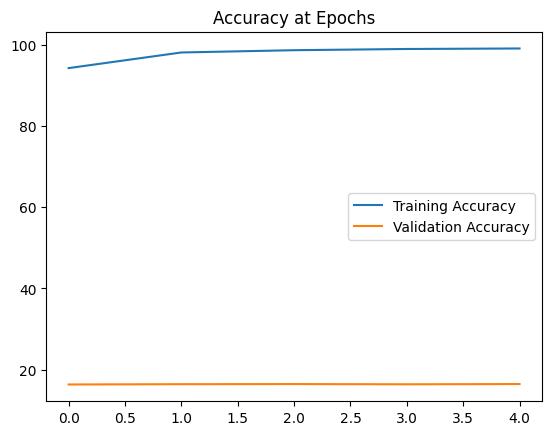

In [ ]:
#graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/600 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at Epochs")
plt.legend()
plt.show()

In [ ]:
test_load_everything=DataLoader(test_data,batch_size=10000,shuffle=False)

In [ ]:
with torch.no_grad():
  correct=0
  for X_test,y_test in test_load_everything:
    y_val=model(X_test)
    predicted=torch.max(y_val.data,1)[1]
    correct+=(predicted==y_test).sum()

In [ ]:
print(correct.item())
print(correct.item()/len(test_data)*100)

9874
98.74000000000001


In [ ]:
#grab a particular image
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
#resape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

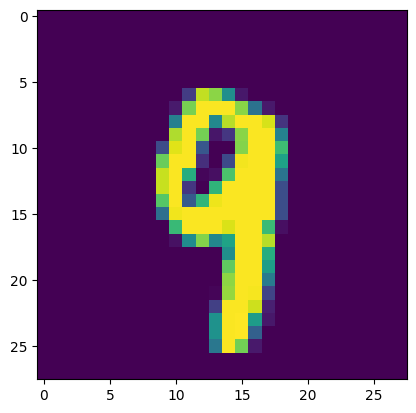

In [ ]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [ ]:
model.eval()
with torch.no_grad():
  y_val=model(test_data[4143][0].reshape(1,1,28,28))

In [ ]:
y_val #new prediction

tensor([[-1.7871e+01, -1.6704e+01, -1.9303e+01, -1.3646e+01, -9.1631e+00,
         -1.6256e+01, -2.5329e+01, -1.2956e+01, -1.0458e+01, -1.3732e-04]])

In [ ]:
y_val.argmax()

tensor(9)